In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'C:/Users/Leonardo/Documents/Repository/Kaggle-CatvsDogs/train' ## Path for training data
TEST_DIR = 'C:/Users/Leonardo/Documents/Repository/Kaggle-CatvsDogs/test1'  ## Path for testing data
IMG_SIZE = 50                                                               ## IMG size scaling
LR = 1e-3                                                                   ## Learning rate

MODEL_NAME = 'leo-catsvsdogs-kaggle-{}--{}.model'.format(LR, '2conv-basic') ## Model name to be sabed

In [2]:
def label_img(img):
    '''
    This function onehot encode the image. The database images 
    names are class.number.format. It takes the image name, split 
    by dot, and takes the first argument, and label the image
    based on the class.
    '''
    word_label = img.split('.')[-3] ## Split the image name by dots
    if word_label == 'cat': return [1,0] 
    elif word_label == 'dog': return [0,1]    

In [3]:
def create_train_data():
    '''
    This function pre-process the training data, labels it,
    put it in a numpy array format, and save it in a numpy
    file
    '''
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [14]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 587.50it/s]
C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tensorflow.python.framework import ops
ops.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
train = train_data[:-500]
test = train_data[-500:]

In [8]:
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_test = [i[1] for i in test]

In [9]:
model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.11641 | time: 78.290s
| Adam | epoch: 003 | loss: 11.11641 - acc: 0.5172 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.19204 | time: 79.491s
| Adam | epoch: 003 | loss: 11.19204 - acc: 0.5139 | val_loss: 11.74318 - val_acc: 0.4900 -- iter: 24500/24500
--


## 51% accuracy

Overall rule: if in 3 epochs your accuracy is not getting any better, it probably won't in 100. Time to increase CNN size, but before...

### Checking tensorboard

Tensorboard --logdir=C:\Users\Leonardo\Documents\Repository\Kaggle-CatvsDogs\log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:21<00:00, 590.39it/s]
C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


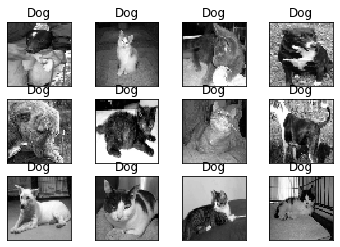

In [15]:
import matplotlib.pyplot as plt

test_data = create_test_data()

fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

## Shoking!

The CNN is classifying everything as dog basically xD

# New CNN with 6 layers

In [17]:
ops.reset_default_graph()

MODEL_NAME = 'leo-catsvsdogs-kaggle-{}--{}.model'.format(LR, '6conv-basic') ## Model name to be sabed

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

# Epochs

accuracy increasing until 10 epochs, trying 15 to get a good result!

In [20]:
model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=5, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 5744  | total loss: 0.34985 | time: 51.154s
| Adam | epoch: 015 | loss: 0.34985 - acc: 0.8530 -- iter: 24448/24500
Training Step: 5745  | total loss: 0.34156 | time: 52.303s
| Adam | epoch: 015 | loss: 0.34156 - acc: 0.8568 | val_loss: 0.47064 - val_acc: 0.7900 -- iter: 24500/24500
--


## 85 % accuracy

So 15 epochs resulted in 85% accuracy...from now on, anything between increasing CNN size or epochs number will
yield better results, with the risk of overfitting your. 
Now it is the developer task to determine if the resulting accuracy is enough. For me, it is a good input for kaggle cats vs dogs, so we will go further, but first..... 

### Checking tensorboard

Tensorboard --logdir=C:\Users\Leonardo\Documents\Repository\Kaggle-CatvsDogs\log

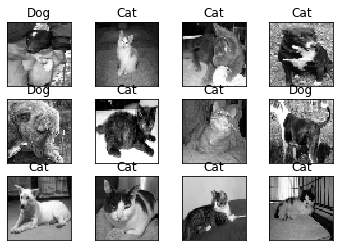

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

## From this sample, we see 2 mistakes, and both are a dog being classified as a cat. 

if you want to improve your results without further increasing epochs number or CNN layers, you should analyze why this "confusion" is happening and try to implement some pre-processing resources to get a better accuracy! 

- Again, for me the results are satisfatory, so I will go on and generate the submission file for the kaggle competition!
    - Competition deadline was in 2013, so for now, you can only submit your results to check your score for fun!!

In [22]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 859.05it/s]
